In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df= pd.read_csv('training_data.csv')
print(df.head())
print(df.shape)

           x          y  label
0  25.206642   9.684294      1
1  28.471634  12.314793      1
2  27.811820  12.342328      1
3  33.709347  18.998068      1
4  26.102421  11.398684      1
(1028, 3)


In [ ]:
print(df['label'].unique())

[1 2]


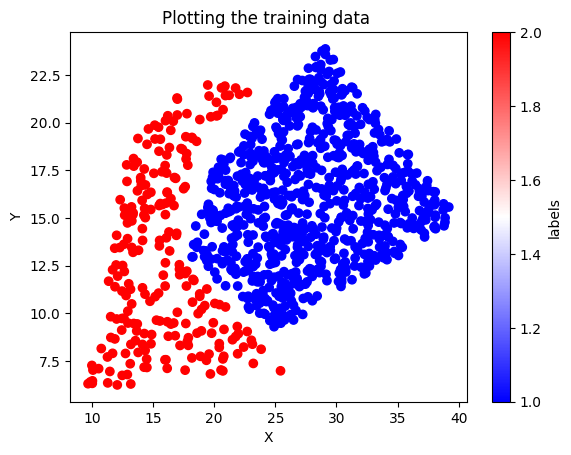

In [ ]:

plot=plt.scatter(x=df['x'] , y=df['y'], c=df['label'] ,cmap='bwr')
plt.colorbar(label='labels')
plt.title("Plotting the training data ")
plt.ylabel('Y')
plt.xlabel('X')
plt.show()

In [ ]:
df_test= pd.read_csv('/content/drive/MyDrive/Machine Learning/test_data.csv')
print(df_test.head())
print(df_test.shape)

           x          y
0  26.916319  16.952214
1  27.190775  20.254873
2  33.866079  18.541124
3  29.925171  11.223172
4  18.672230  11.506035
(258, 2)


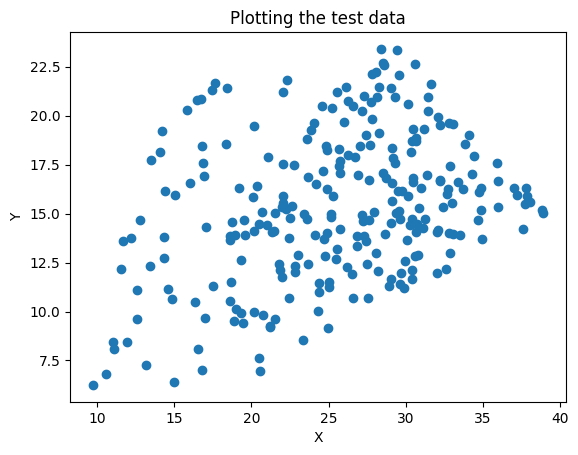

In [ ]:

plot=plt.scatter(x=df_test['x'] , y=df_test['y'])
plt.title("Plotting the test data")
plt.ylabel('Y')
plt.xlabel('X')
plt.show()

# Loss Metrics

## first I calculated confusion matrix using true and predicted values. Then i used indexing of this confusion matrix to calculate precision, recall, and specificity. then calculated f1-score using precision and recall. In the end combined all these functions to be executed step by step using custom function.

In [ ]:
def confusion_matrix(true, pred):
    no_classes=len(true.unique())
    confusion_ma=np.zeros((no_classes,no_classes))
    for true_val, pred_val in zip(true, pred):
        confusion_ma[true_val-1, pred_val-1]+=1
    return confusion_ma
def recall(confusion_matrix):
    ans= confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0])
    return ans
def precision(confusion_matrix):
    ans= confusion_matrix[0][0]/sum(confusion_matrix[0])
    return ans
def specificity(confusion_matrix):
    ans= confusion_matrix[-1][-1]/(confusion_matrix[-1][-1]+confusion_matrix[0][-1])
    return ans
def f1_score(precision, recall):
    ans= 2*precision*recall/(precision+recall)
    return ans
def all_metrices(y_true,y_pred):
    cm=confusion_matrix(y_true,y_pred)
    precision_val=precision(cm)
    recall_val=recall(cm)
    f1_val = f1_score(precision_val, recall_val)
    return f'\nprecision: {precision_val},\nrecall: {recall_val},\nf1-score: {f1_val}'
def custom_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    precision_val = precision(cm)
    recall_val = recall(cm)
    f1_val = f1_score(precision_val, recall_val)
    return f1_val

custom_scorer = make_scorer(custom_score, greater_is_better=True)

# Visualizing the decision boundary
## I created this function to visualize the decision boundary. this function takes X=['x' ,'y'] training data, Y= label and the model which is visualized.

## It calculates the max and min range of the 'x' and 'y' values of X. It then generates all the points in this min to max range with a very fine interval of 0.01. Then it uses this data to predict the Y values using the model and then plot the contour accurately marking the decision boundary for the whole space.

## After this it plots the X and Y scatter plot over the contour to visualize the data points with respect to the decision boundary.

In [ ]:
def plot_decision_boundary(X, y, model):
    # Create a mesh grid for plotting the decision boundary
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict on the mesh grid to create a decision boundary
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    # Scatter plot of the training points, colored by label
    scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y.values.ravel(), edgecolors='k', cmap=plt.cm.coolwarm)

    # Create a legend for the labels
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend1)

    # Add titles and labels
    plt.title("Decision Tree Classifier Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Show the plot
    plt.show()


# Data Preparation

## Splitting the data into train X=['x', 'y'] and Y= label.
## Creating test data using same shape and format of training data.

In [ ]:
X_train= df[['x','y']].copy()
Y_train=df['label'].copy()
X_test=df_test[['x','y']].copy()

# **Decision Tree**
### ->   GridSearchCV is used for parameter tuning and finding the best parameter for best results.
### ->Decision tree is implemented using Scikit-learn library.
### ->I have executed the code and copied the best model in the variable `best_tree_params` to reduce the runtime. You can use the commented line to generate the original parameter tuning results.
### ->I have using my custom coded loss function to tune the parameter using make_scorer function of gridsearch which allows a function or callable as evaluator.
## Parameters explanation
- **`max_depth`**: Limits the tree's maximum depth to control overfitting and model complexity.
- **`min_samples_split`**: Sets the minimum samples required to split an internal node.
 - **`min_samples_leaf`**: Specifies the minimum samples a leaf node must contain.
- **`criterion`**: Defines the function to measure the spliting criterion (e.g., Gini or Entropy).
- **`max_leaf_nodes`**: Caps the maximum number of leaf nodes in the tree.
- **`min_impurity_decrease`**: Splits a node only if the impurity reduction exceeds this threshold.


In [ ]:

param_grid = {
    'max_depth': [3, 5, 8, 10, 15, 20, 25, 30, 35],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 5, 10, 15],
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes': [None, 10, 20, 30, 50, 100, 500, 1000],
    'min_impurity_decrease': [0.0, 0.01, 0.1]
}
best_tree_params = {
    'criterion': ['gini'],
    'max_depth': [8],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0],
    'min_samples_leaf': [1],
    'min_samples_split': [2]
}

# grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring=custom_scorer, cv=[(slice(None), slice(None))])
grid_search = GridSearchCV(DecisionTreeClassifier(), best_tree_params, scoring=custom_scorer, cv=[(slice(None), slice(None))])

grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
Y_pred=pd.DataFrame(grid_search.best_estimator_.predict(X_train)).squeeze()

print(all_metrices(Y_train,Y_pred))
print(f'f1 score from manual calculation: {custom_score(Y_train,Y_pred)}')


print("Best Parameters:", best_params)
print("Best Score (F1) from gridsearch:", grid_search.best_score_)




precision: 1.0,
recall: 1.0,
f1-score: 1.0
f1 score from manual calculation: 1.0
Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score (F1) from gridsearch: 1.0


# Plots
- fig-1: Scatter plot of the Training data with labels
- fig-1: Scatter plot of the Training data with predicted labels
- fig-1: Scatter plot of the Test data with predicted labels

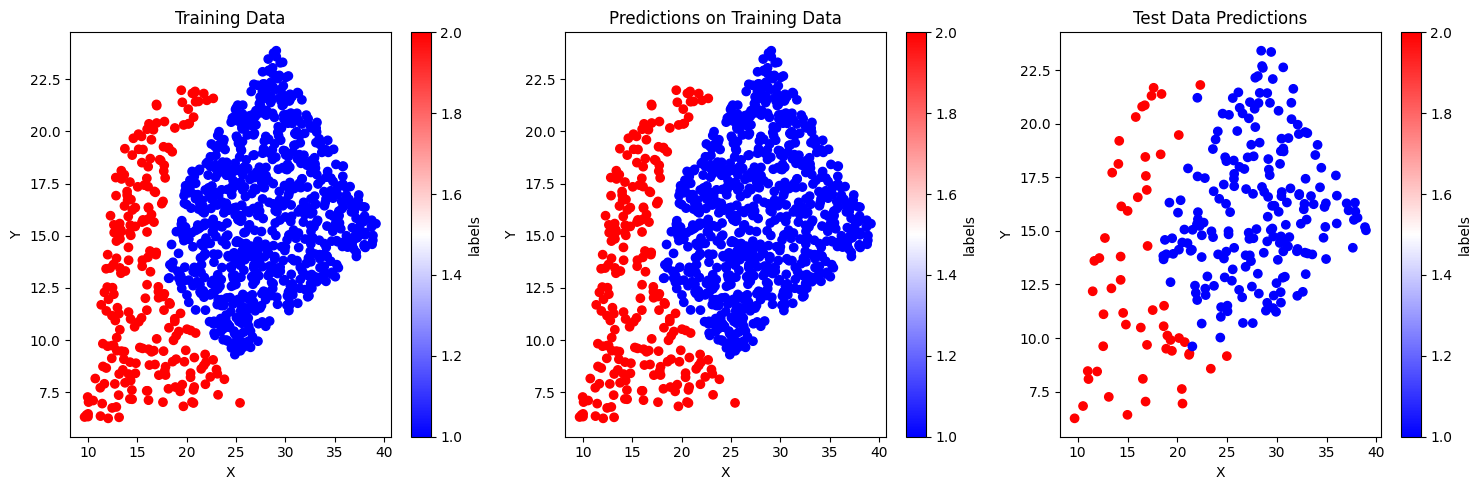

In [ ]:

Y_test_pred=pd.DataFrame(grid_search.best_estimator_.predict(X_test)).squeeze()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

scatter1 = axs[0].scatter(x=df['x'], y=df['y'], c=df['label'], cmap='bwr')
axs[0].set_title("Training Data")
axs[0].set_ylabel('Y')
axs[0].set_xlabel('X')
fig.colorbar(scatter1, ax=axs[0], label='labels')

scatter2 = axs[1].scatter(x=df['x'], y=df['y'], c=Y_pred, cmap='bwr')
axs[1].set_title("Predictions on Training Data")
axs[1].set_ylabel('Y')
axs[1].set_xlabel('X')
fig.colorbar(scatter2, ax=axs[1], label='labels')

scatter3 = axs[2].scatter(x=df_test['x'], y=df_test['y'], c=Y_test_pred, cmap='bwr')
axs[2].set_title("Test Data Predictions")
axs[2].set_ylabel('Y')
axs[2].set_xlabel('X')
fig.colorbar(scatter3, ax=axs[2], label='labels')

plt.tight_layout()
plt.show()

# Saving the output in TEXT file.


In [ ]:

file_path = "/content/drive/MyDrive/Machine Learning/Decision_tree_output.txt"

with open(file_path, "w") as file:
    for value in Y_test_pred:
        file.write(f"{value}\n")

print("successfully")


successfully


# Combined Plotting of training and testing data

### for combined plotting of training and testing data, I have merged the X-training and X-testing as it is. But for Y, I have added +2 in Test predicted to create 4 classes 1,2,3,4, where 1- class 1 from training data, 2- class 2 from training data, 3- class 1 from test data and 4- class 2 from test data.

(1286, 2)
(1286, 1)


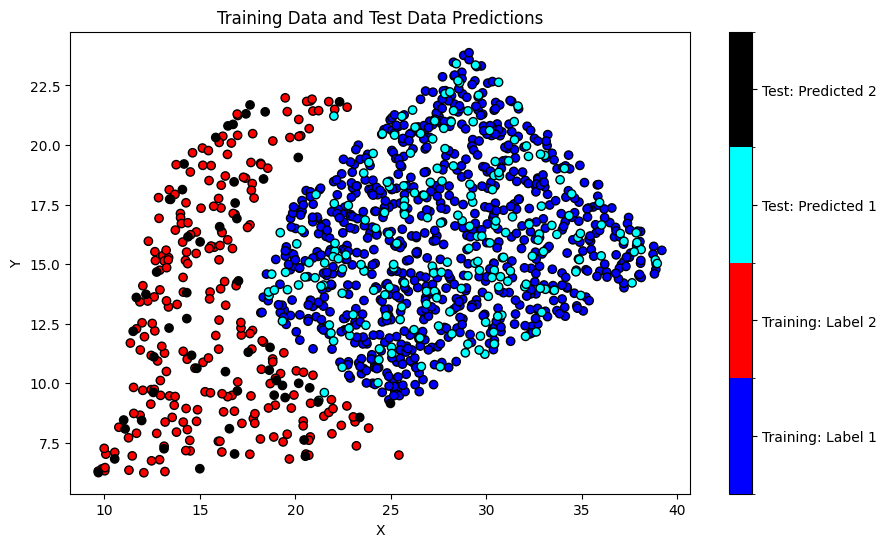

In [ ]:


x_combined  = pd.concat([X_train, df_test], axis=0, ignore_index=True)
print(x_combined.shape)

labels_combined = pd.concat([ Y_train, Y_test_pred + 2 ], axis=0, ignore_index=True)
print(labels_combined.shape)

cmap = mcolors.ListedColormap(['blue', 'red', 'cyan', 'black'])
norm = mcolors.BoundaryNorm([1, 2, 3, 4, 5], cmap.N)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_combined['x'], x_combined['y'], c=labels_combined, cmap=cmap, norm=norm, edgecolors='k')


cbar = plt.colorbar(scatter, ticks=[1.5, 2.5, 3.5, 4.5])
cbar.ax.set_yticklabels(['Training: Label 1', 'Training: Label 2', 'Test: Predicted 1', 'Test: Predicted 2'])


plt.title("Training Data and Test Data Predictions")
plt.xlabel('X')
plt.ylabel('Y')

plt.show()


# Decision Boundary Plotting

### working of the decision boundary ploting function is explained above
### here i am using only training data to plot with the decision boundary to visualize how the training instances influence the boundary of the decision.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


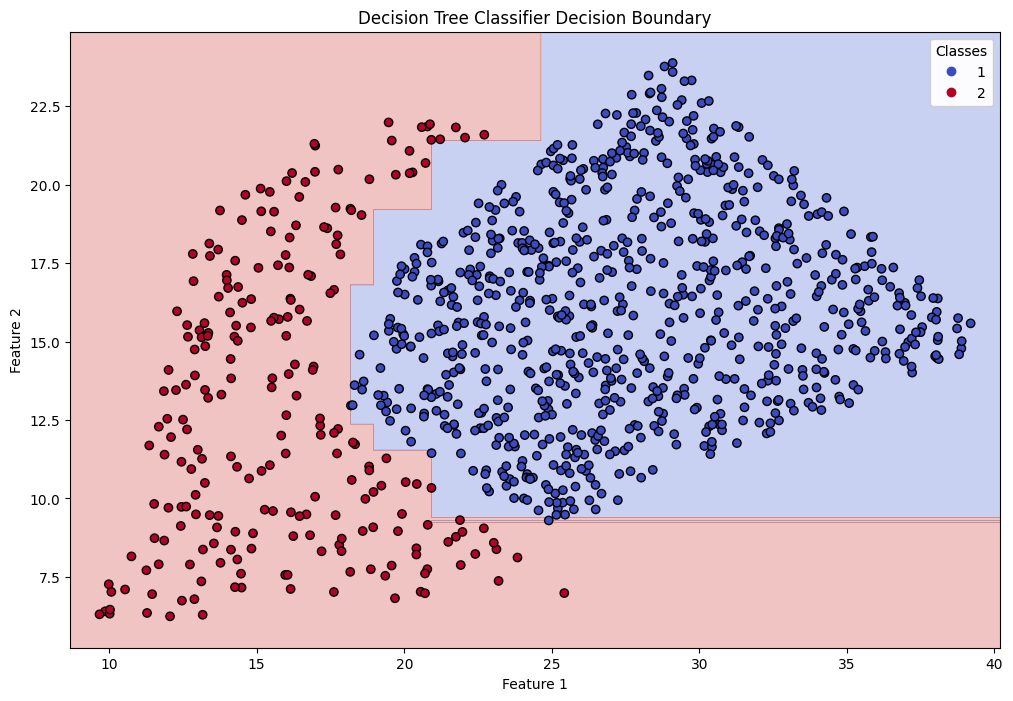

In [ ]:
plot_decision_boundary(X_train,Y_train,best_model)

# Decision Boundary Plot
### here I am using Training and Test data to visualize how the data is spread in the data space, the boundary line and classification of test data based on its position with respect to decision boundary in the data space.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


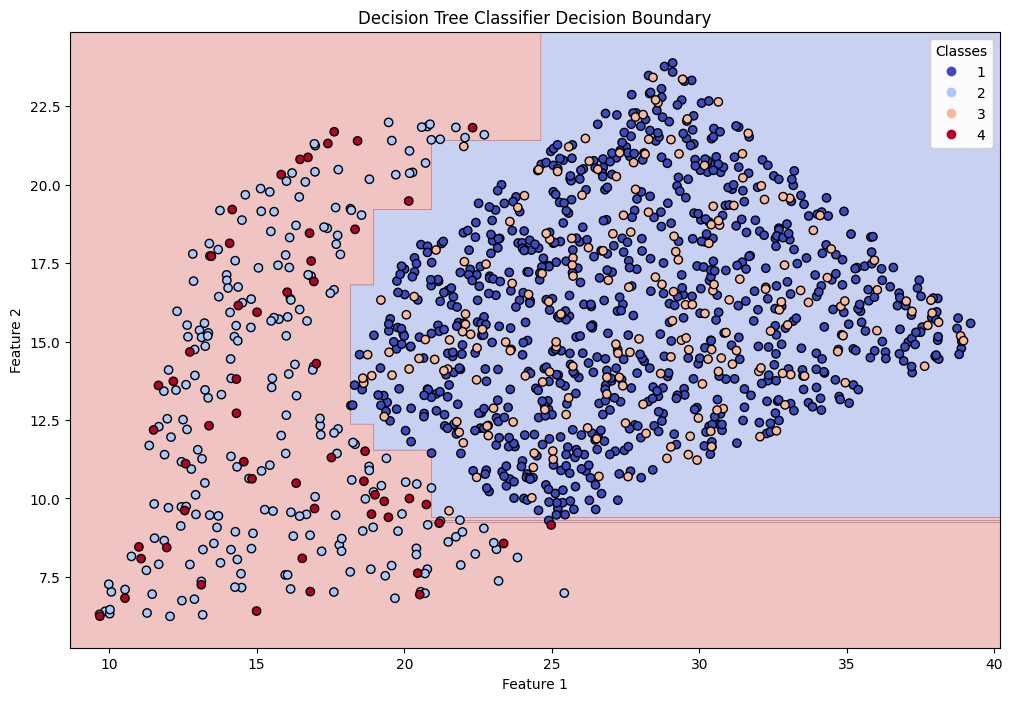

In [ ]:
plot_decision_boundary(x_combined,labels_combined,best_model)

# **Random Forest Classifier**

### ->   GridSearchCV is used for parameter tuning and finding the best parameter for best results.
### ->Random Forest is implemented using Scikit-learn library.
### ->I have executed the code to find best parameters and copied the best parameters in the variable `best_params_rf` to reduce the runtime. You can use the commented line to generate the original parameter tuning results.
### ->I have using my custom coded loss function to tune the parameter using make_scorer function of gridsearch which allows a function or callable as evaluator.

## Random Forest Hyperparameters

- **n_estimators**: The number of trees to build in the forest. Higher values can improve performance but increase training time.

- **max_features**: The number of features to consider when looking for the best split. Options include:
  - `'sqrt'`: Use the square root of the total number of features.
  - `'log2'`: Use the logarithm (base 2) of the total number of features.
  - `None`: Use all features.

- **max_depth**: The maximum depth of each tree. Deeper trees capture more complexity but can lead to overfitting.

- **min_samples_split**: The minimum number of samples required to split an internal node. Higher values prevent overly deep trees.

- **min_samples_leaf**: The minimum number of samples required to be at a leaf node. Higher values prevent small splits and help reduce overfitting.

- **criterion**: The function used to measure the quality of a split:
  - `'gini'`: Gini impurity.
  - `'entropy'`: Information gain.


In [ ]:

param_grid_rf = {
    'n_estimators': [50, 100 , 200],
    'max_features': [ 'sqrt', 'log2', None],
    'max_depth': [None , 10 , 50 , 100],
    'min_samples_split': [2, 5 , 10, 20 ],
    'min_samples_leaf': [1, 2  , 5, 15],
    'criterion': ['gini', 'entropy'],
}

best_params_rf ={
      'n_estimators': [50 ],
      'max_features': ['sqrt'],
      'max_depth': [None ],
      'min_samples_split': [2 ],
      'min_samples_leaf': [1],
      'criterion': ['gini'],
      'random_state': [30]  # Ensures consistent results. these seeds also works well 6,7, 14 ,15,17,19,21,24,30, 33,34,35,38,41,42,45, 48
}
grid_search = GridSearchCV(RandomForestClassifier(), best_params_rf,  scoring=custom_scorer, cv=[(slice(None), slice(None))])

grid_search.fit(X_train, Y_train)
print('best Parameters: ', grid_search.best_params_,'\n best Score:', grid_search.best_score_)
best_model_rf=grid_search.best_estimator_



best Parameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 30} 
 best Score: 1.0


# Classification
### The following code classifies the training and test data and store it in dataframe format

In [ ]:
y_pred_train_rf = pd.DataFrame(grid_search.best_estimator_.predict(X_train)).squeeze()
Y_test_pred_rf=pd.DataFrame(grid_search.best_estimator_.predict(X_test)).squeeze()

# Saving the output in TEXT file.


In [ ]:

file_path = "/content/drive/MyDrive/Machine Learning/Random_Forest_output.txt"

with open(file_path, "w") as file:
    for value in Y_test_pred_rf:
        file.write(f"{value}\n")

print("successfully")

successfully


# Metrics Results


In [ ]:
final_score = all_metrices(Y_train , y_pred_train_rf)
print("Final result of metrices on Full Dataset:", final_score)

Final result of metrices on Full Dataset: 
precision: 1.0,
recall: 1.0,
f1-score: 1.0


# Plots
- fig-1: Scatter plot of the Training data with labels
- fig-1: Scatter plot of the Training data with predicted labels
- fig-1: Scatter plot of the Test data with predicted labels

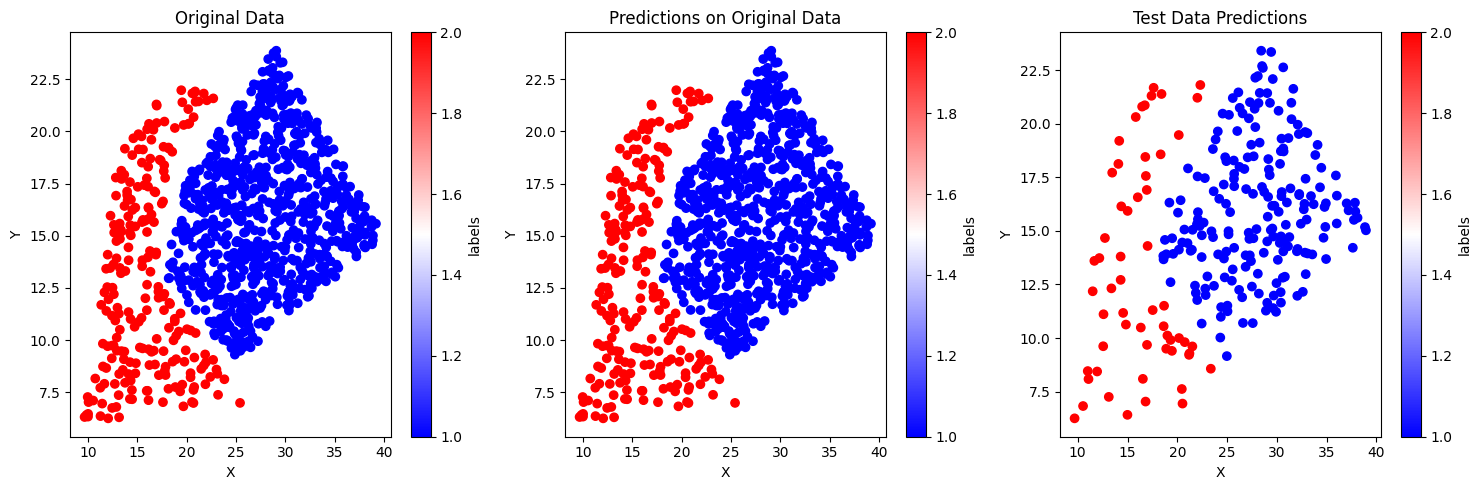

In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

scatter1 = axs[0].scatter(x=df['x'], y=df['y'], c=df['label'], cmap='bwr')
axs[0].set_title("Original Data")
axs[0].set_ylabel('Y')
axs[0].set_xlabel('X')
fig.colorbar(scatter1, ax=axs[0], label='labels')

scatter2 = axs[1].scatter(x=df['x'], y=df['y'], c=y_pred_train_rf, cmap='bwr')
axs[1].set_title("Predictions on Original Data")
axs[1].set_ylabel('Y')
axs[1].set_xlabel('X')
fig.colorbar(scatter2, ax=axs[1], label='labels')

scatter3 = axs[2].scatter(x=df_test['x'], y=df_test['y'], c=Y_test_pred_rf, cmap='bwr')
axs[2].set_title("Test Data Predictions")
axs[2].set_ylabel('Y')
axs[2].set_xlabel('X')
fig.colorbar(scatter3, ax=axs[2], label='labels')

plt.tight_layout()
plt.show()

# Combined Plotting of training and testing data

### for combined plotting of training and testing data, I have merged the X-training and X-testing as it is. But for Y, I have added +2 in Test predicted to create 4 classes 1,2,3,4, where 1- class 1 from training data, 2- class 2 from training data, 3- class 1 from test data and 4- class 2 from test data.

(1286, 2)
(1286, 1)


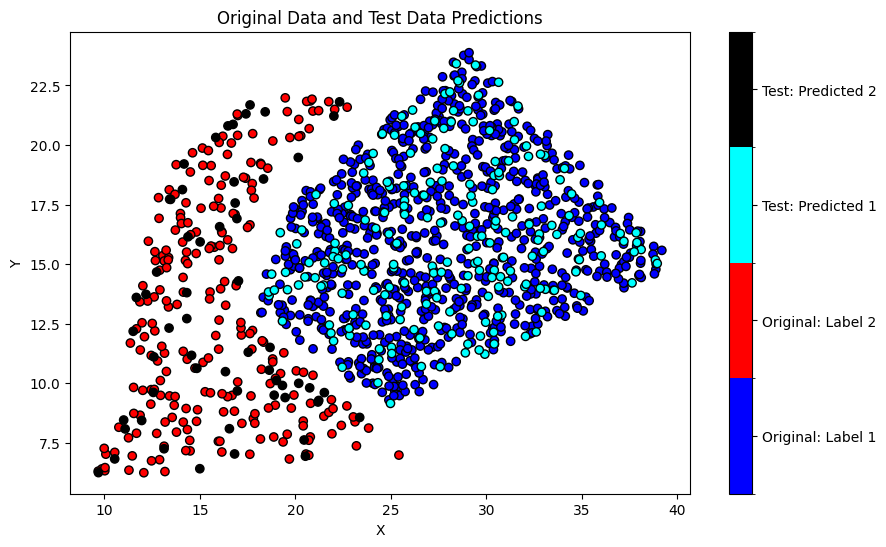

In [ ]:
x_combined  = pd.concat([X_train, df_test], axis=0, ignore_index=True)
print(x_combined.shape)

labels_combined_rf = pd.concat([ Y_train, pd.DataFrame(Y_test_pred_rf) + 2 ], axis=0, ignore_index=True)
print(labels_combined_rf.shape)

cmap = mcolors.ListedColormap(['blue', 'red', 'cyan', 'black'])
norm = mcolors.BoundaryNorm([1, 2, 3, 4, 5], cmap.N)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_combined['x'], x_combined['y'], c=labels_combined_rf, cmap=cmap, norm=norm, edgecolors='k')


cbar = plt.colorbar(scatter, ticks=[1.5, 2.5, 3.5, 4.5])
cbar.ax.set_yticklabels(['Original: Label 1', 'Original: Label 2', 'Test: Predicted 1', 'Test: Predicted 2'])


plt.title("Original Data and Test Data Predictions")
plt.xlabel('X')
plt.ylabel('Y')

# Show the plot
plt.show()

# Decision Boundary Plotting

### working of the decision boundary ploting function is explained above
### here i am using only training data to plot with the decision boundary to visualize how the training instances influence the boundary of the decision.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


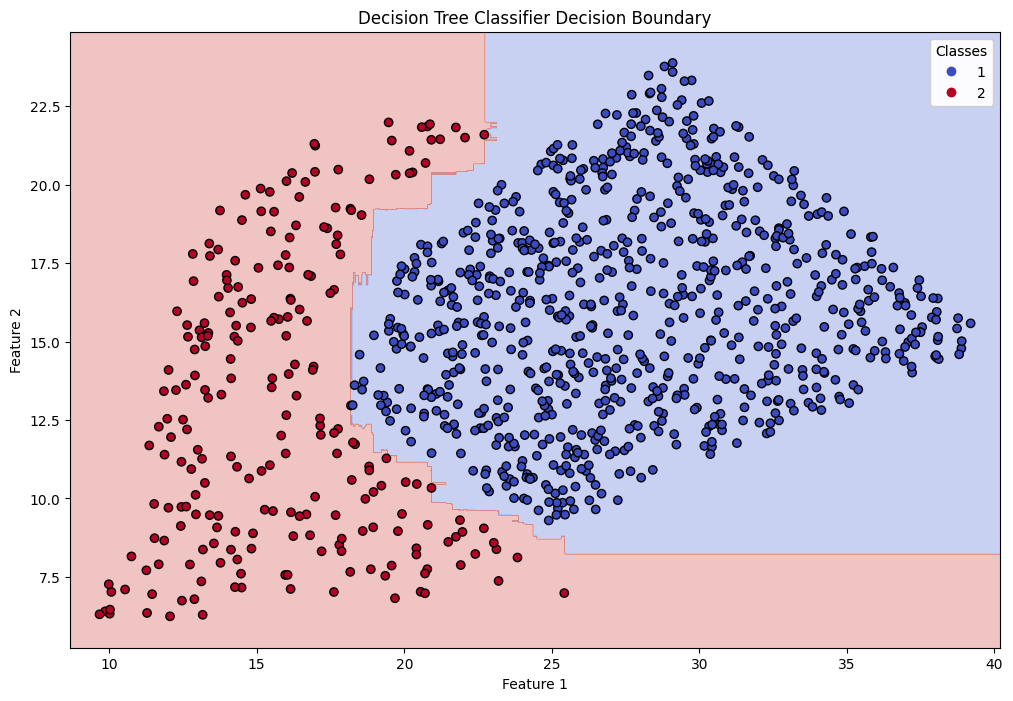

In [ ]:
plot_decision_boundary(X_train,Y_train,best_model_rf)

# Decision Boundary Plot
### here I am using Training and Test data to visualize how the data is spread in the data space, the boundary line and classification of test data based on its position with respect to decision boundary in the data space.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


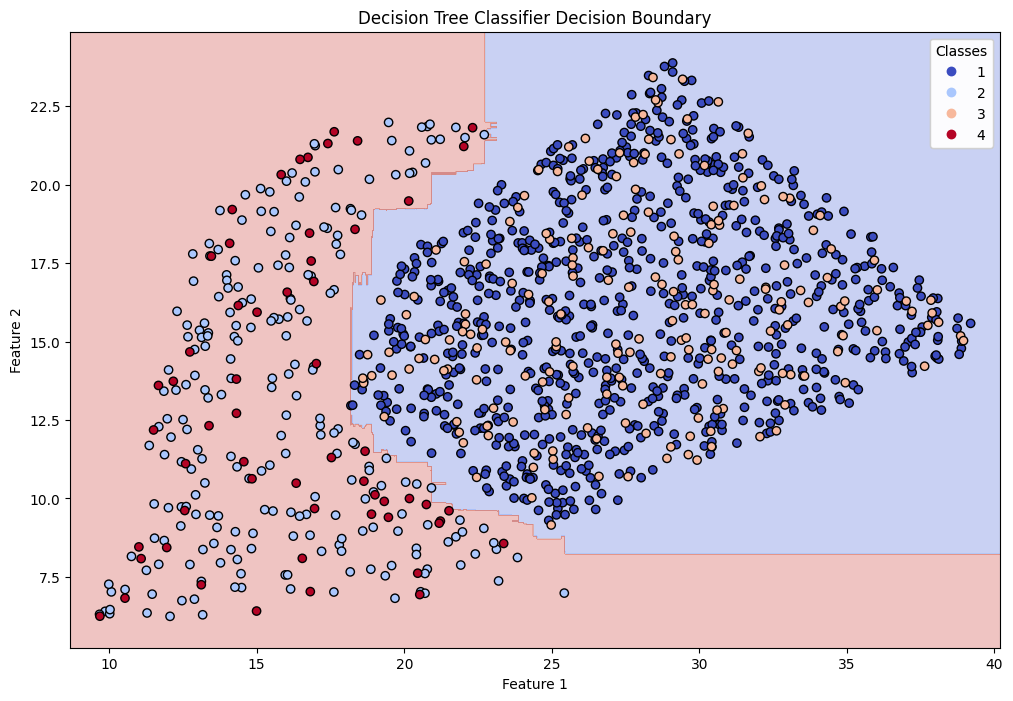

In [ ]:
plot_decision_boundary(x_combined,labels_combined_rf ,best_model_rf)

# **K-Nearest Neighbour Classifier**

### ->   GridSearchCV is used for parameter tuning and finding the best parameter for best results.
### ->Random Forest is implemented using Scikit-learn library.
### ->I have executed the code to find best parameters and copied the best parameters in the variable `best_params_knn` to reduce the runtime. You can use the commented line to generate the original parameter tuning results.
### ->I have using my custom coded loss function to tune the parameter using make_scorer function of gridsearch which allows a function or callable as evaluator.

## K-Nearest Neighbors (KNN) Hyperparameters

- **n_neighbors**: The number of neighbors to consider when making predictions. A higher number of neighbors leads to smoother decision boundaries.

- **weights**: The weight function used in prediction:
  - `'uniform'`: All neighbors are weighted equally.
  - `'distance'`: Closer neighbors are given more weight.

- **metric**: The distance metric used to compute the distance between points:
  - `'euclidean'`: Standard straight-line distance.
  - `'manhattan'`: Sum of absolute differences.
  - `'chebyshev'`: Maximum absolute coordinate difference.
  - `'minkowski'`: Generalization of both Euclidean and Manhattan distance.

- **algorithm**: The algorithm used to compute nearest neighbors:
  - `'auto'`: Automatically selects the best algorithm.
  - `'ball_tree'`, `'kd_tree'`: Tree-based methods for efficient search.
  - `'brute'`: A brute-force search of all neighbors.

- **leaf_size**: The size of the leaf in tree-based algorithms. Smaller values may increase tree depth but make searches faster.


In [ ]:

param_grid_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
}
best_params_knn= {
     'algorithm': ['auto'],
     'leaf_size': [10],
     'metric': ['euclidean'],
     'n_neighbors': [1],
     'weights': ['uniform']
}

# grid_search = GridSearchCV(KNeighborsClassifier(), param_grid_knn,  scoring=custom_scorer, cv=[(slice(None), slice(None))])
grid_search = GridSearchCV(KNeighborsClassifier(), best_params_knn,  scoring=custom_scorer, cv=[(slice(None), slice(None))])
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_, grid_search.best_score_)

best_model_knn=grid_search.best_estimator_


{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'} 1.0


# Classification
### The following code classifies the training and test data and store it in dataframe format

In [ ]:
y_pred_train_knn = pd.DataFrame(grid_search.best_estimator_.predict(X_train)).squeeze()
Y_test_pred_knn=pd.DataFrame(grid_search.best_estimator_.predict(X_test)).squeeze()

# Saving the output in TEXT file.


In [ ]:

file_path = "/content/drive/MyDrive/Machine Learning/KNN_output.txt"

with open(file_path, "w") as file:
    for value in Y_test_pred_knn:
        file.write(f"{value}\n")

print("successfully")

successfully


# Metrics Results

In [ ]:
final_score = all_metrices(Y_train , y_pred_train_rf)
print("Final result of metrices on Full Dataset:", final_score)

Final result of metrices on Full Dataset: 
precision: 1.0,
recall: 1.0,
f1-score: 1.0


# Plots
- fig-1: Scatter plot of the Training data with labels
- fig-1: Scatter plot of the Training data with predicted labels
- fig-1: Scatter plot of the Test data with predicted labels

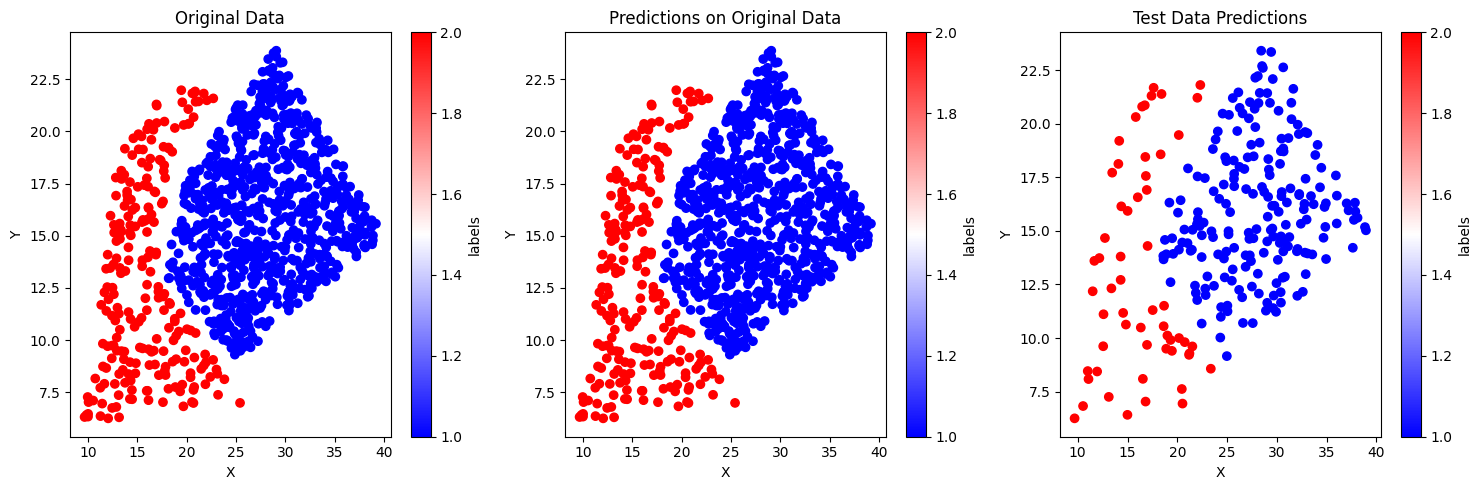

In [ ]:
labels_combined_knn=pd.concat([Y_train, Y_test_pred_knn+2],axis=0, ignore_index=True)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

scatter1 = axs[0].scatter(x=df['x'], y=df['y'], c=df['label'], cmap='bwr')
axs[0].set_title("Original Data")
axs[0].set_ylabel('Y')
axs[0].set_xlabel('X')
fig.colorbar(scatter1, ax=axs[0], label='labels')

scatter2 = axs[1].scatter(x=df['x'], y=df['y'], c=y_pred_train_knn, cmap='bwr')
axs[1].set_title("Predictions on Original Data")
axs[1].set_ylabel('Y')
axs[1].set_xlabel('X')
fig.colorbar(scatter2, ax=axs[1], label='labels')

scatter3 = axs[2].scatter(x=df_test['x'], y=df_test['y'], c=Y_test_pred_knn, cmap='bwr')
axs[2].set_title("Test Data Predictions")
axs[2].set_ylabel('Y')
axs[2].set_xlabel('X')
fig.colorbar(scatter3, ax=axs[2], label='labels')

plt.tight_layout()
plt.show()

# Decision Boundary Plotting

### working of the decision boundary ploting function is explained above
### here i am using only training data to plot with the decision boundary to visualize how the training instances influence the boundary of the decision.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


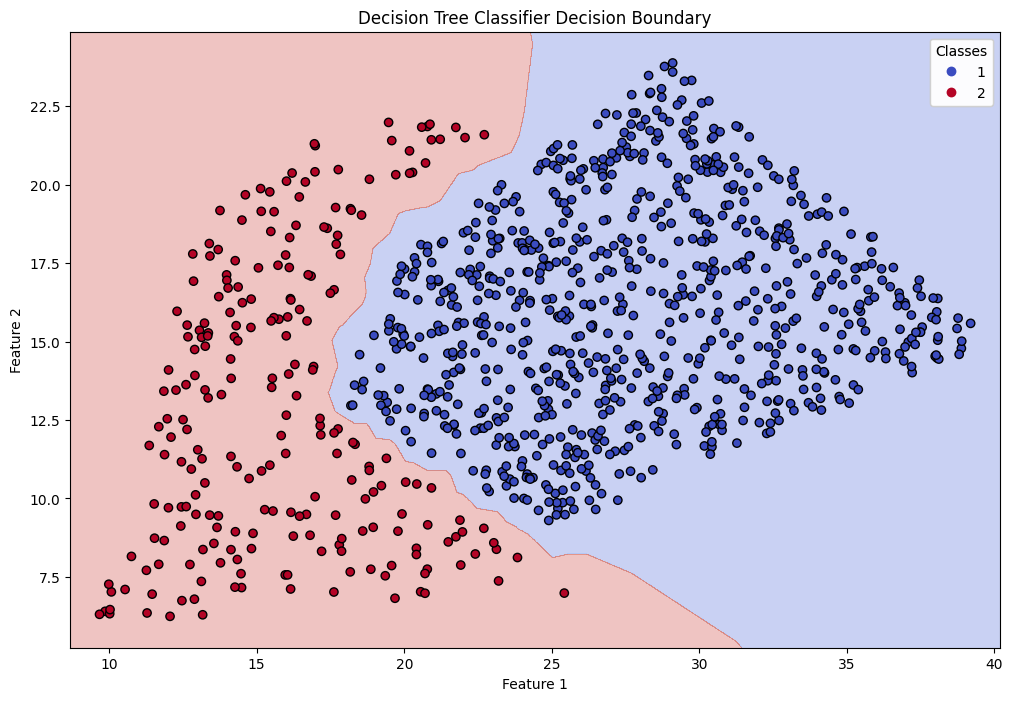

In [ ]:
plot_decision_boundary(X_train, Y_train, best_model_knn)

# Combined Plotting of training and testing data

### for combined plotting of training and testing data, I have merged the X-training and X-testing as it is. But for Y, I have added +2 in Test predicted to create 4 classes 1,2,3,4, where 1- class 1 from training data, 2- class 2 from training data, 3- class 1 from test data and 4- class 2 from test data.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


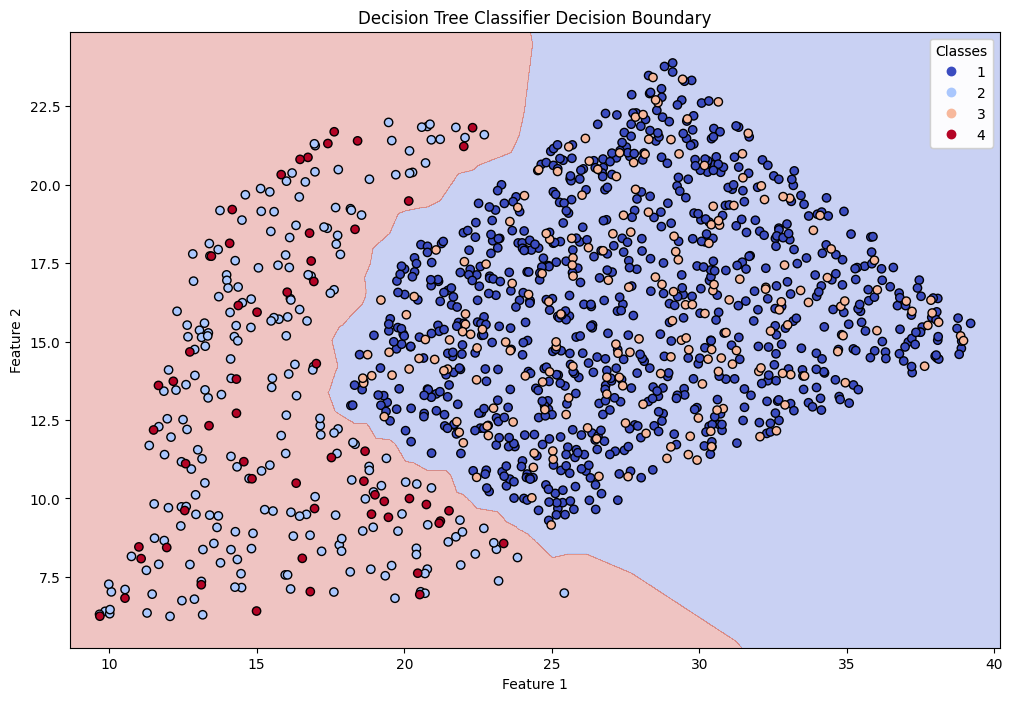

In [ ]:
plot_decision_boundary(x_combined, labels_combined_knn, best_model_knn)

# **Logistic Regression**


### ->   GridSearchCV is used for parameter tuning and finding the best parameter for best results.
### ->Random Forest is implemented using Scikit-learn library.
### ->I have executed the code to find best parameters and copied the best parameters in the variable `best_params_log_reg` to reduce the runtime. You can use the commented line to generate the original parameter tuning results.
### ->I have using my custom coded loss function to tune the parameter using make_scorer function of gridsearch which allows a function or callable as evaluator.
## Logistic Regression Hyperparameters

- **penalty**: The type of regularization used to prevent overfitting:
  - `'l1'`: Lasso regularization (encourages sparsity by driving some coefficients to zero).
  - `'l2'`: Ridge regularization (penalizes large coefficients to reduce model complexity).

- **C**: The inverse of regularization strength (smaller values mean stronger regularization). Higher values allow the model to fit more closely to the training data.

- **solver**: The optimization algorithm to use for finding the model coefficients:
  - `'liblinear'`: Suitable for small datasets and supports both L1 and L2 penalties.
  - `'saga'`: Supports both L1 and L2 penalties, and is efficient for large datasets.

- **max_iter**: The maximum number of iterations the solver will run before stopping. Higher values allow for more time to converge but may increase computation time.

- **tol**: The tolerance for stopping criteria. Lower values make the solver more precise, but it may take longer to converge.

- **class_weight**: Used to handle imbalanced datasets:
  - `None`: No class weighting, treats all classes equally.
  - `'balanced'`: Automatically adjusts weights inversely proportional to class frequencies in the training data.


In [ ]:

param_grid_log_reg = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    'max_iter': [200, 300, 400, 500],
    'tol': [1e-4, 1e-3],
    'class_weight': [None, 'balanced'],
}
best_param_log_reg={
    'C': [1],
    'class_weight': [None],
    'max_iter': [200],
    'penalty': ['l1'],
    'solver': ['liblinear'],
    'tol': [0.0001] }

# grid_search = GridSearchCV(LogisticRegression(), param_grid_log_reg, scoring='accuracy', cv=[(slice(None), slice(None))], verbose=1, n_jobs=-1)
grid_search = GridSearchCV(LogisticRegression(), best_param_log_reg, scoring='accuracy',cv=[(slice(None), slice(None))] , verbose=1, n_jobs=-1)

grid_search.fit(X_train, Y_train)

best_model_logreg = grid_search.best_estimator_
print('best Parameters: ', grid_search.best_params_,'\nbest score: ', grid_search.best_score_)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
best Parameters:  {'C': 1, 'class_weight': None, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001} 
best score:  0.9513618677042801


# Classification
### The following code classifies the training and test data and store it in dataframe format

In [ ]:
y_pred_train_logreg = pd.DataFrame(best_model_logreg.predict(X_train)).squeeze()
Y_test_pred_logreg=pd.DataFrame(best_model_logreg.predict(X_test)).squeeze()

# Saving the output in TEXT file.


In [ ]:
file_path = "/content/drive/MyDrive/Machine Learning/Logistic_Regression_output.txt"

with open(file_path, "w") as file:
    for value in Y_test_pred_logreg:
        file.write(f"{value}\n")

print("successfully")

successfully


# Plots
- fig-1: Scatter plot of the Training data with labels
- fig-1: Scatter plot of the Training data with predicted labels
- fig-1: Scatter plot of the Test data with predicted labels

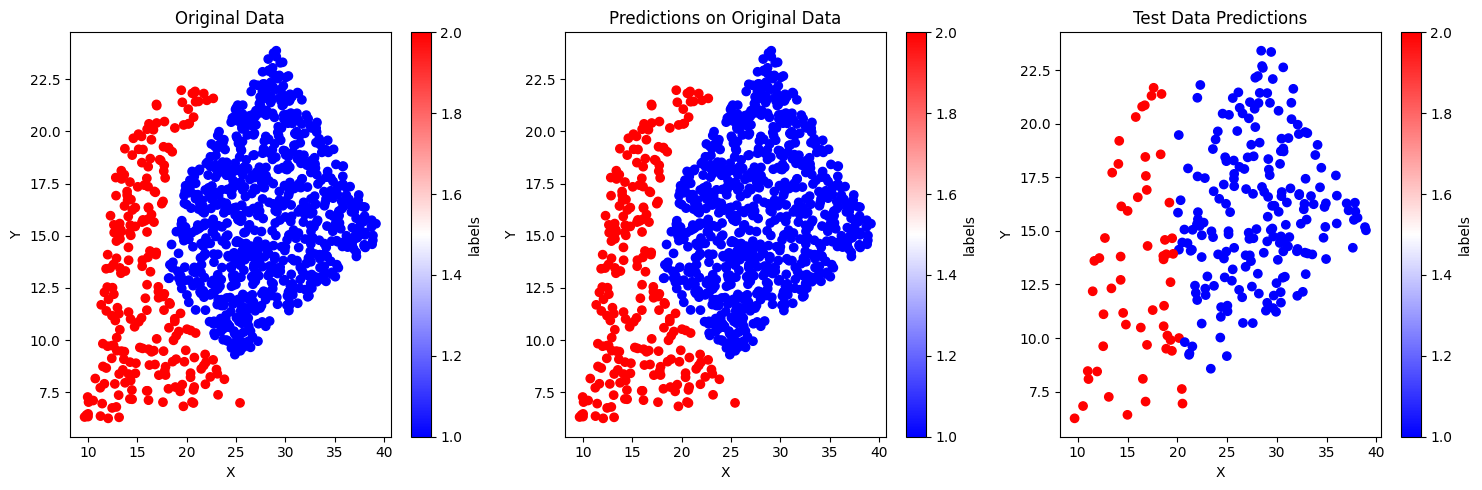

In [ ]:

labels_combined_logreg=pd.concat([Y_train, Y_test_pred_logreg+2],axis=0, ignore_index=True)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

scatter1 = axs[0].scatter(x=df['x'], y=df['y'], c=df['label'], cmap='bwr')
axs[0].set_title("Original Data")
axs[0].set_ylabel('Y')
axs[0].set_xlabel('X')
fig.colorbar(scatter1, ax=axs[0], label='labels')

scatter2 = axs[1].scatter(x=df['x'], y=df['y'], c=y_pred_train_knn, cmap='bwr')
axs[1].set_title("Predictions on Original Data")
axs[1].set_ylabel('Y')
axs[1].set_xlabel('X')
fig.colorbar(scatter2, ax=axs[1], label='labels')

scatter3 = axs[2].scatter(x=df_test['x'], y=df_test['y'], c=Y_test_pred_logreg, cmap='bwr')
axs[2].set_title("Test Data Predictions")
axs[2].set_ylabel('Y')
axs[2].set_xlabel('X')
fig.colorbar(scatter3, ax=axs[2], label='labels')

plt.tight_layout()
plt.show()

# Decision Boundary Plotting

### working of the decision boundary ploting function is explained above
### here i am using only training data to plot with the decision boundary to visualize how the training instances influence the boundary of the decision.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


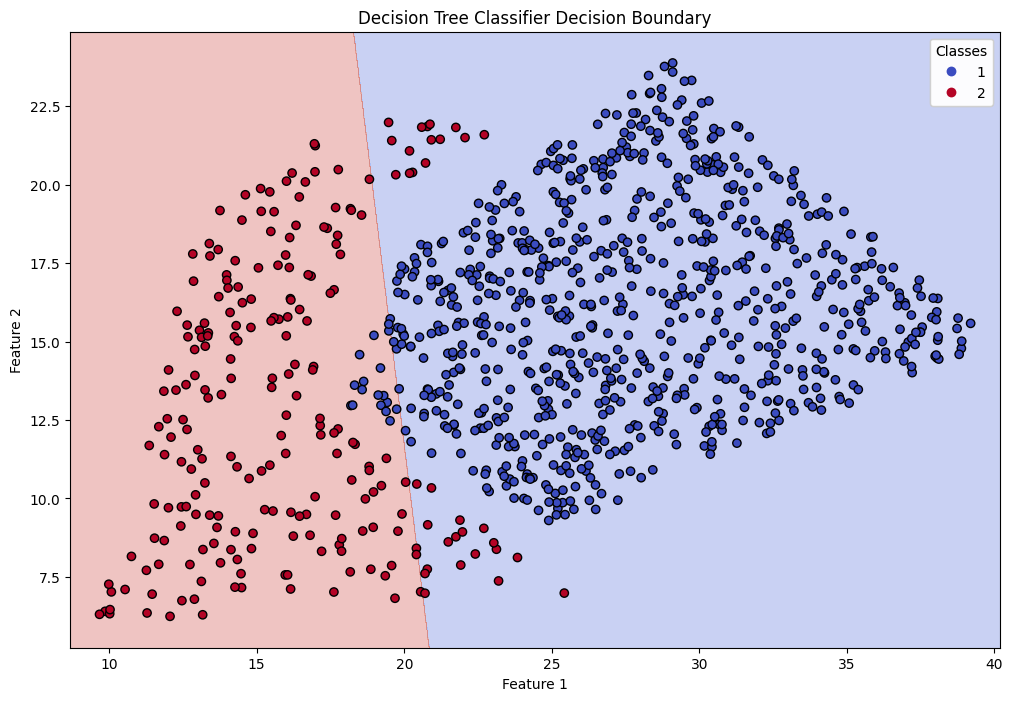

In [ ]:
plot_decision_boundary(X_train, Y_train, best_model_logreg)

# Combined Plotting of training and testing data

### for combined plotting of training and testing data, I have merged the X-training and X-testing as it is. But for Y, I have added +2 in Test predicted to create 4 classes 1,2,3,4, where 1- class 1 from training data, 2- class 2 from training data, 3- class 1 from test data and 4- class 2 from test data.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


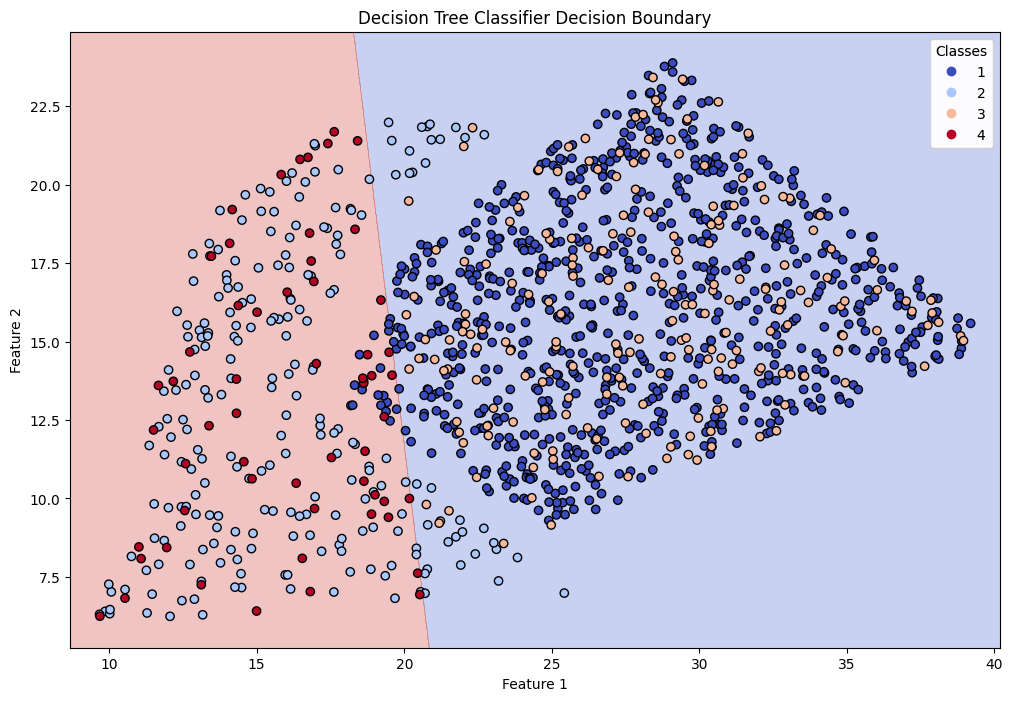

In [ ]:
plot_decision_boundary(x_combined, labels_combined_logreg, best_model_logreg)

# **FINAL RESULT**
### we can clearly see from the above plots and metrics that ***KNN and Random Forest gives best results*** on the training and test but, but from the plots we can observe that KNN has better and consistent boundary than Random Forest. Then we have ***Decision tree*** which is also ***almost perfect*** execpt 1 miss-classification in test data. then we have ***logistic regression*** which give the ***good overall*** classification result but poor compared to others.